# Analysis Template

## Preprocess

In [1]:
# resolve dependency
# !pip install pmdarima

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from pandas.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
import statsmodels.api as sm
from pmdarima.arima import ADFTest , auto_arima
%matplotlib inline

In [3]:
data_path = "C:/crime_project/data/theft_occurrence_per_day/part-00000-be9030c7-0e3c-470e-9041-419bcc83f5d9-c000.csv"
crime = "type2"
target = "Count"
date = "Date"
city = "chicago"
fig_size = (20,5)

In [4]:
df_by_day = pd.read_csv(data_path)
df_by_day[date] = pd.to_datetime(df_by_day[date])
df_by_day.set_index(date, inplace=True)

## Profiling

### By day

In [5]:
df_by_day.head()

,Count
Date,
2001-01-01,413
2001-01-02,221
2001-01-03,226
2001-01-04,243
2001-01-05,265


In [6]:
df_by_day.describe()

,Count
count,9086.000000
mean,197.417125
std,57.932395
min,5.000000
25%,157.000000
50%,192.000000
75%,235.000000
max,567.000000


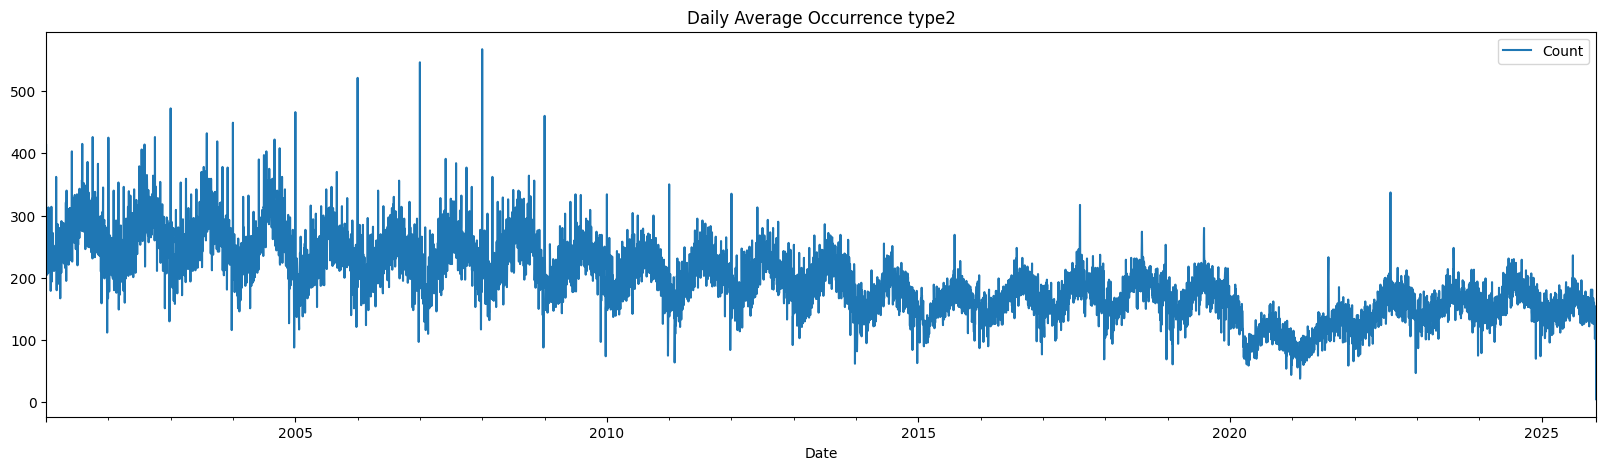

In [7]:
df_by_day.plot(figsize=fig_size, title="Daily Average Occurrence " + crime)
plt.show()

In [8]:
df_by_day[target].sort_values(ascending=False).head()

Date
2008-01-01    567
2007-01-01    546
2006-01-01    521
2003-01-01    472
2005-01-01    466
Name: Count, dtype: int64

### By week

In [9]:
df_by_week = pd.DataFrame(df_by_day[target].resample('W').mean())

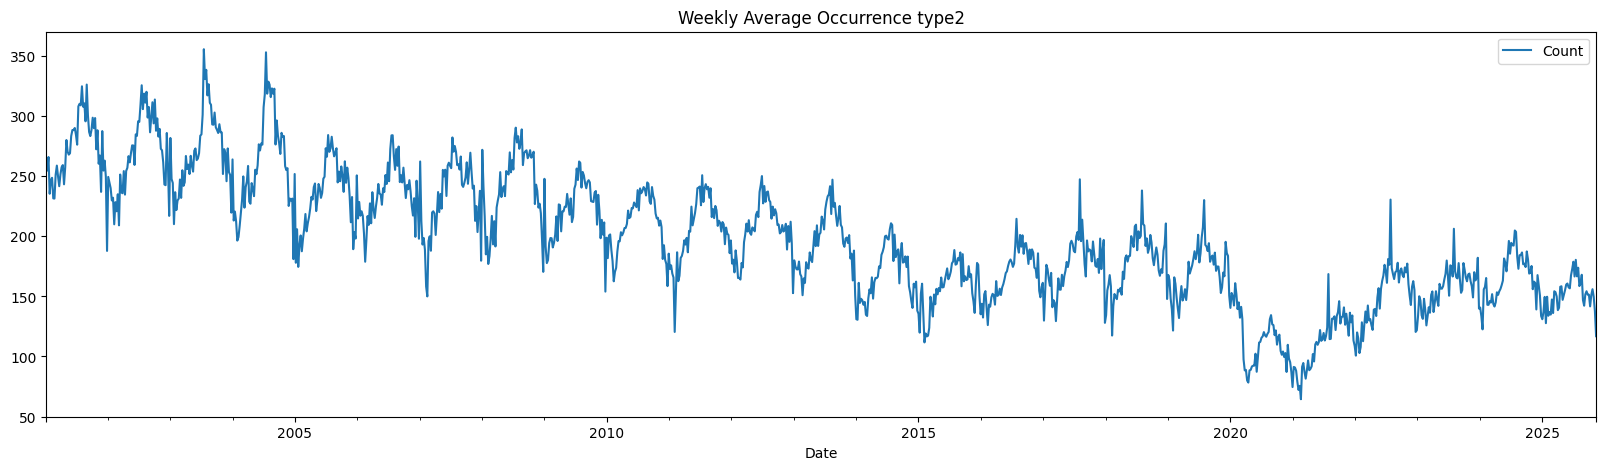

In [10]:
df_by_week.plot(
    figsize=fig_size,
    title="Weekly Average Occurrence " + crime)
plt.show()

### By month

In [11]:
df_by_month = pd.DataFrame(df_by_day[target].resample('M').mean())

C:\Users\nancy\AppData\Local\Temp\ipykernel_22360\261612041.py:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_by_month = pd.DataFrame(df_by_day[target].resample('M').mean())


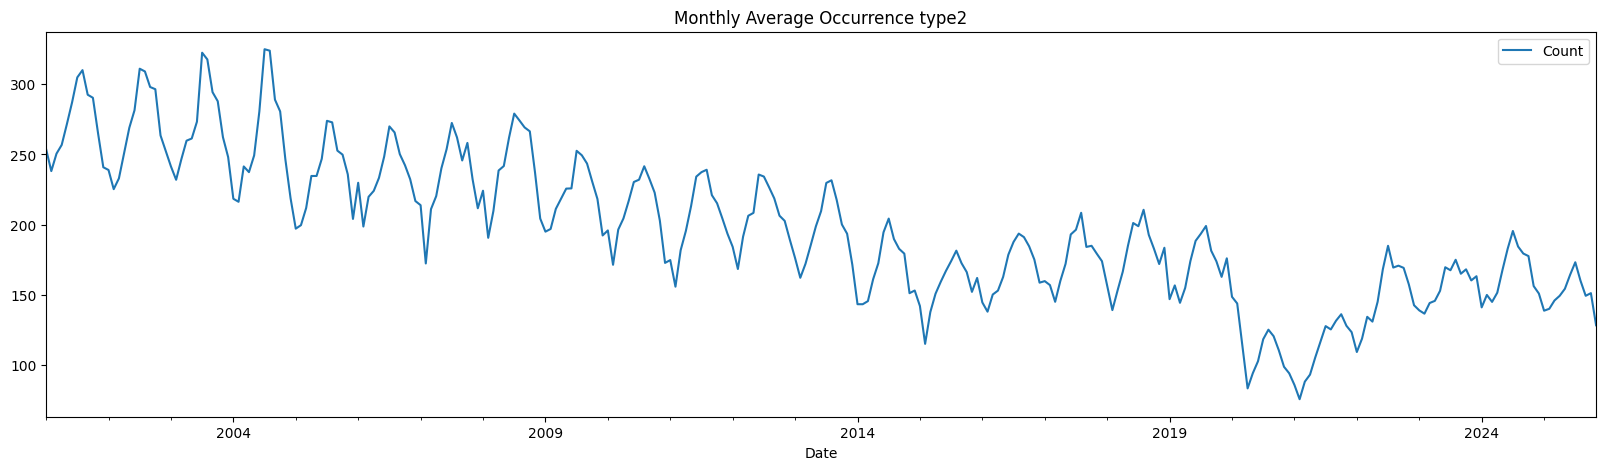

In [12]:
df_by_month.plot(
    figsize=fig_size, 
    title="Monthly Average Occurrence " + crime)
plt.show()

## Analysis

In [13]:
#Ho: It is non stationary
#H1: It is stationary

def adfuller_test(count):
    result=adfuller(count)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")

### Checking stationary

In [14]:
adfuller_test(df_by_month[target])

ADF Test Statistic : -1.3348980500919636
p-value : 0.6130590939246272
#Lags Used : 13
Number of Observations Used : 285
weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 


### Checking seasonality

In [15]:
df_by_month['seasonal_first_difference'] = df_by_month[target] - df_by_month[target].shift(12)

In [16]:
adfuller_test(df_by_month['seasonal_first_difference'].dropna())

ADF Test Statistic : -4.128649016738558
p-value : 0.0008681424418593739
#Lags Used : 12
Number of Observations Used : 274
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary


<Axes: title={'center': 'Seasonal difference plot - type2'}, xlabel='Date'>

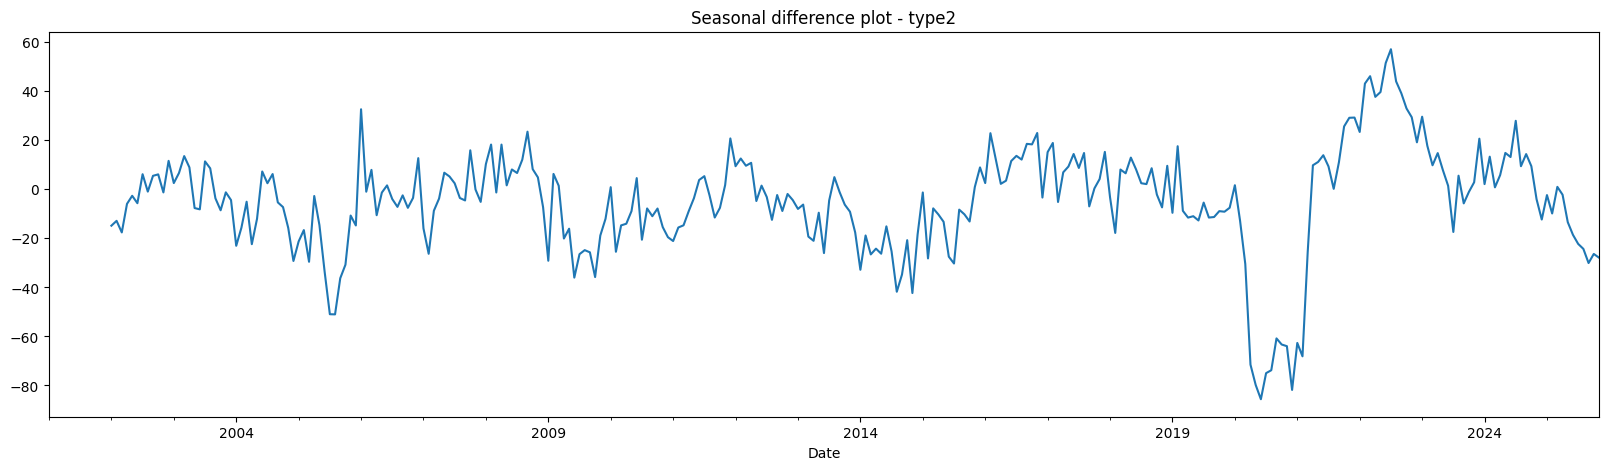

In [17]:
df_by_month['seasonal_first_difference'].plot(figsize=fig_size, title='Seasonal difference plot - ' + crime)

### Auto Regressive Model

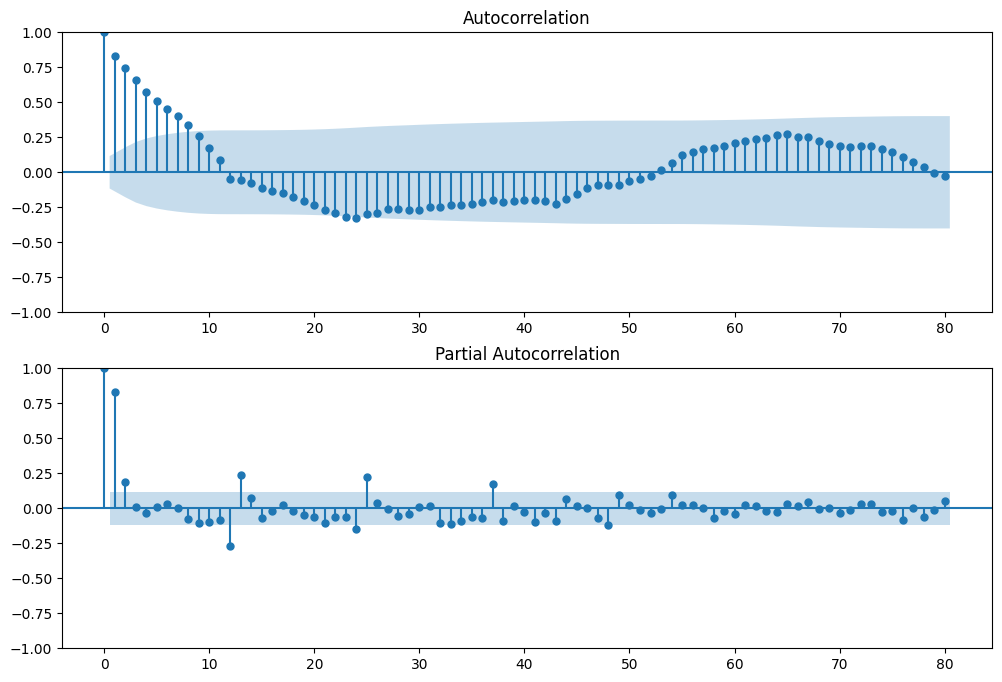

In [18]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df_by_month['seasonal_first_difference'].iloc[13:],lags=80,ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df_by_month['seasonal_first_difference'].iloc[13:],lags=80,ax=ax2)

### Implementing Seasonal Arima Model

In [19]:
adf_test=ADFTest(alpha=0.05)
adf_test.should_diff(df_by_month[target])

(np.float64(0.040393822551722386), np.False_)

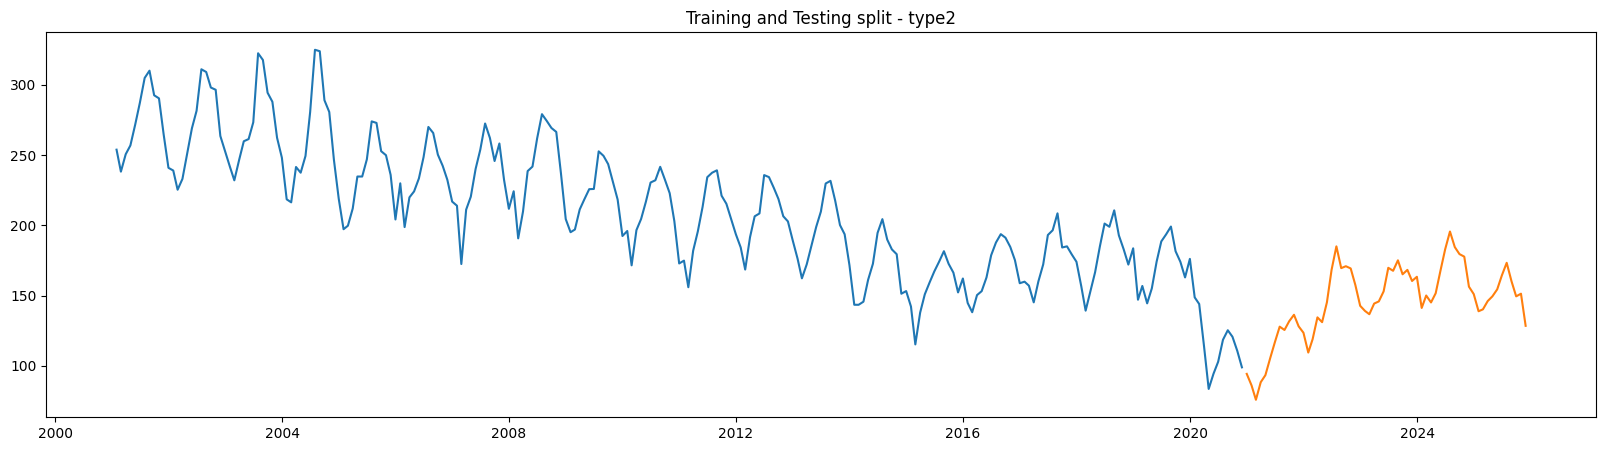

In [20]:
start=int(df_by_month.shape[0]*0.8)
train=df_by_month[:start]
test=df_by_month[start:]
plt.figure(figsize=fig_size)
plt.plot(train[target])
plt.plot(test[target])
plt.title('Training and Testing split - '+ crime)
plt.show()

In [21]:
model=auto_arima(train[target],start_p=0,d=1,start_q=0,
          max_p=10,max_d=10,max_q=10, start_P=0,
          D=1, start_Q=0, max_P=10,max_D=10,
          max_Q=10, m=12, seasonal=True,
          error_action='warn',trace=True,
          supress_warnings=True,stepwise=True,
          random_state=20,n_fits=50)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1793.108, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1749.050, Time=0.15 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=1718.372, Time=0.19 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=1768.452, Time=0.05 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=1718.972, Time=0.28 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=1718.156, Time=0.37 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=1718.795, Time=0.58 sec
 ARIMA(0,1,1)(0,1,3)[12]             : AIC=1715.659, Time=0.85 sec
 ARIMA(0,1,1)(1,1,3)[12]             : AIC=1713.598, Time=1.74 sec
 ARIMA(0,1,1)(2,1,3)[12]             : AIC=1714.794, Time=2.71 sec
 ARIMA(0,1,1)(1,1,4)[12]             : AIC=1714.920, Time=3.05 sec
 ARIMA(0,1,1)(0,1,4)[12]             : AIC=1713.629, Time=1.92 sec
 ARIMA(0,1,1)(2,1,2)[12]             : AIC=1713.025, Time=1.34 sec
 ARIMA(0,1,1)(2,1,1)[12]             : AIC=1715.869, Time=0.53 sec
 ARIMA(0,1,1)(3,1,2

In [22]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                        SARIMAX Results                                        
===============================================================================================
Dep. Variable:                                       y   No. Observations:                  239
Model:             SARIMAX(0, 1, 1)x(2, 1, [1, 2], 12)   Log Likelihood                -850.512
Date:                                 Fri, 05 Dec 2025   AIC                           1713.025
Time:                                         14:15:05   BIC                           1733.548
Sample:                                     01-31-2001   HQIC                          1721.307
                                          - 11-30-2020                                         
Covariance Type:                                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.3308      0.051     -6.475      0.000      -0.431      -0.231
ar.S.L12       0.9135      0.165      5.529      0.000       0.590       1.237
ar.S.L24      -0.3609      0.124     -2.905      0.004      -0.604      -0.117
ma.S.L12      -1.5408      0.169     -9.130      0.000      -1.872      -1.210
ma.S.L24       0.7817      0.135      5.784      0.000       0.517       1.047
sigma2       102.4571      7.860     13.035      0.000      87.051     117.863
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):                65.94
Prob(Q):                              0.88   Prob(JB):                         0.00
Heteroskedasticity (H):               1.04   Skew:                            -0.36
Prob(H) (two-sided):                  0.86   Kurtosis:                         5.55
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

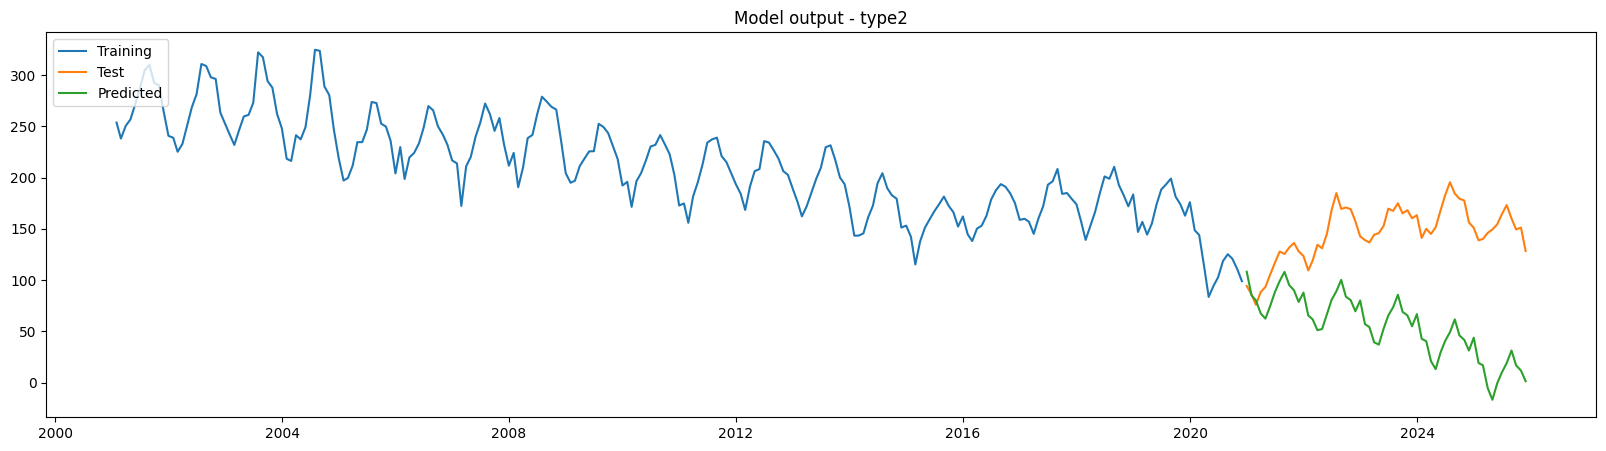

In [23]:
prediction = pd.DataFrame(model.predict(n_periods = train.shape[0]),index=test.index)
prediction.columns = ['predicted_crime']
plt.figure(figsize=fig_size)
plt.plot(train[target],label="Training")
plt.plot(test[target],label="Test")
plt.plot(prediction,label="Predicted")
plt.legend(loc = 'upper left')
plt.savefig('C:/crime_project/output/screenshot/%s_%s_pred.jpg' % (city,crime))
plt.title('Model output - '+crime)
plt.show()

In [24]:
np.sqrt(np.square(np.subtract(test[target].values,prediction['predicted_crime'].values)).mean())

np.float64(101.39618770437609)